# Preprocessing

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from skimage.util.shape import view_as_windows

## Displaying a Sample Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (1000, 3600, 3)


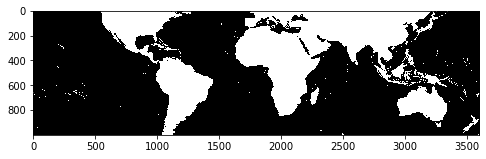

In [2]:
#this reads in an image from the dataset and then displays it
correct_orientation_images_path = Path(r'D:\BSc (Hons) Computer Sciences\2020\Big Data Engineering\Group Project\Preprocessing\correct orientation')

for img_path in correct_orientation_images_path.glob('*.png'):          
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    print("Image shape: {}".format(img.shape))
    break

plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='gray')
plt.show()

## Cropping Images

In [3]:
#this function crops the area of Bangladesh from the images in the dataset
def crop_images(dataset_path, new_dataset_path):
    for img_path in dataset_path.glob('*.png'):    
        try:
            img_name = str(img_path).split("\\")[-1]
            image = Image.open(img_path)
            image2 = image.crop((2650, 175, 2770, 300))
            image2 = image2.resize((40, 40))
            image2.save(new_dataset_path / img_name)
        except FileNotFoundError:
            pass
        
#set the path where the cropped images should be stored
cropped_images_path = Path(r'D:\BSc (Hons) Computer Sciences\2020\Big Data Engineering\Group Project\Preprocessing\bangladesh 2')
#crop_images(correct_orientation_images_path, cropped_images_path)

In [ ]:
#this takes the cropped images and separates them into training and testing images
from keras.preprocessing import image

train = []
test = []
counter = 0

for img_path in cropped_images_path.glob('*.png'):
    if counter < 100:
        img = image.load_img(img_path, target_size=(40, 40), grayscale=True)
        img = image.img_to_array(img)
        img = np.array(img).reshape(40, 40)
        train.append(img)
    elif counter >= 150:
        continue
    else:
        img = image.load_img(img_path, target_size=(40, 40), grayscale=True)
        img = image.img_to_array(img)
        img = np.array(img).reshape(40, 40)
        test.append(img)
    counter+=1

In [ ]:
train = np.array(train)
test = np.array(test)
print(train.shape)
print(test.shape)

## Creating Sequences of Pixels 

In [ ]:
#this adds some weighting to the pixels values in a neighborhood around a specific pixel
def pixel_weighting(L):
    result=[]
    for r in range(L.shape[0]):
        for c in range(L.shape[1]):
            array = np.array(L[r][c]).flatten()
            pixel_of_interest_1 = array[4]
            pixel_of_interest_2 = array[4]
            for index in range(array.shape[0]):
                if index==4:
                    continue
                elif array[index] > pixel_of_interest_1:
                    pixel_of_interest_2 = pixel_of_interest_2 + array[index]*0.00
                elif array[index] < pixel_of_interest_1:
                    pixel_of_interest_2 = pixel_of_interest_2 - array[index]*0.00
            if pixel_of_interest_2 < 0:
                pixel_of_interest_2 = 0
            result.append(pixel_of_interest_2)
            
    return np.array(result).reshape(L.shape[0], L.shape[1])

#creates sequence of images
def gettingSequence(X, sequence_length, months_ahead, neighborhood_size=(3, 3)):
    
    Y=[]
    dataX = []
    
    for num in range(X.shape[0]-(sequence_length + months_ahead)+1):
        sequence=[]
        for i in range(sequence_length+months_ahead):
            if (i < sequence_length):
                #just taking the average of the neighborhood pixels in the meantime
                A = np.pad(X[i+num], 1, mode='constant')
                neighborhoods = view_as_windows(A, neighborhood_size)
                
                B = pixel_weighting(neighborhoods).flatten()
                
                
                sequence.append(B)
                
            elif (i == (sequence_length+months_ahead-1)):
                Y.append(X[i+num].flatten())
                
            if (i == sequence_length-1):        
                dataX.append(sequence)
                
    return dataX, Y

#this creates a sequence of pixels
def create_training_dataset(X_seq, GT):
    X1 = []
    Y = []
    for sample_no in range(X_seq.shape[0]):
        x = X_seq[sample_no].T #T is just the transpose function on matrices
        y = GT[sample_no]
        for i in range(x.shape[0]):
            X1.append(x[i])
            Y.append(y[i])
    return X1, np.array(Y).flatten()


In [ ]:
def create_big_data_files(sequence_length, months_ahead):
    #getting sequences and ground truth for those sequences using a specified sequence length and the number of months ahead
    X_sequences_train, ground_truth_train = gettingSequence(train, sequence_length, months_ahead)
    X_sequences_test, ground_truth_test = gettingSequence(test, sequence_length, months_ahead)
    #converting to numpy arrays
    X_sequences_train = np.array(X_sequences_train)
    ground_truth_train = np.array(ground_truth_train)
    X_sequences_test = np.array(X_sequences_test)
    ground_truth_test = np.array(ground_truth_test)
    
    num_of_images = ground_truth_test.shape[0]
    #here we create sequences of pixels
    train_X, train_Y = create_training_dataset(X_sequences_train, ground_truth_train)
    test_X, test_Y = create_training_dataset(X_sequences_test, ground_truth_test)
    #converting to numpy arrays
    train_X = np.array(train_X)
    train_Y = np.array(train_Y)
    test_X = np.array(test_X)
    test_Y = np.array(test_Y)
    
    #all these statements does is that it creates a pandas dataframe using the sequence of pixels we created above
    if sequence_length == 4:
        train_df = pd.DataFrame(train_X, columns=["M1", "M2", "M3", "M4"])
        test_df = pd.DataFrame(test_X, columns=["M1", "M2", "M3", "M4"])
    elif sequence_length == 8:
        train_df = pd.DataFrame(train_X, columns=["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8"])
        test_df = pd.DataFrame(test_X, columns=["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8"])

    elif sequence_length == 12:
        train_df = pd.DataFrame(train_X, columns=["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "M10", "M11", "M12"])
        test_df = pd.DataFrame(test_X, columns=["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "M10", "M11", "M12"])

    train_df['GT'] = train_Y
    test_df['GT'] = test_Y
    #setting the name of the files 
    train_file_name = r"Preprocessed Data\train_sequence_length_"+str(sequence_length)+"_month_ahead_"+str(months_ahead)+".txt"
    test_file_name = r"Preprocessed Data\test_sequence_length_"+str(sequence_length)+"_month_ahead_"+str(months_ahead)+".txt"
    #storing the pandas dataframes which hold the sequence of pixels to a text file which will then be stored in Hadoop HDFS
    train_df.to_csv(train_file_name)
    test_df.to_csv(test_file_name)

In [ ]:
#creating the files used to the 1 month ahead predictions
create_big_data_files(4, 1)
create_big_data_files(8, 1)
create_big_data_files(12, 1)

In [ ]:
#creating the files used to the 2 months ahead predictions
create_big_data_files(4, 2)
create_big_data_files(8, 2)
create_big_data_files(12, 2)

In [ ]:
#creating the files used to the 3 months ahead predictions
create_big_data_files(4, 3)
create_big_data_files(8, 3)
create_big_data_files(12, 3)

## Creating Flatten Image Dataset

In [ ]:
#here we read in the cropped images again so that we can flatten each image. 
#These flattened images will be used to do some analysis using Spark
from keras.preprocessing import image

images_path = Path(r'D:\BSc (Hons) Computer Sciences\2020\Big Data Engineering\Group Project\Preprocessing\Bangladesh')

images = []
counter = 0

for img_path in images_path.glob('*.png'):
    img = image.load_img(img_path, target_size=(40, 40), grayscale=True)
    img = image.img_to_array(img)
    img = np.array(img).reshape(40, 40)
    images.append(img)

#images array
images = np.array(images)

In [ ]:
#this flattens each image array
def flatten_images(array):
    result = []
    for i in range(array.shape[0]):
        result.append(list(array[i].flatten()))
    return np.array(result)


images_flatten = flatten_images(images)
#convert flattened image array to pandas dataframe so that we can store it in a text file
images_df = pd.DataFrame(images_flatten)
#storing the pandas dataframe in a text file
images_df.to_csv(r'Preprocessed Data\images_flatten.txt', sep=',', encoding='utf-8', header=None)